# NCAA ML Model

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import csv
import sys
import os
from sklearn import svm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
# %matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.linear_model import LogisticRegression

## Goals

Given the regular season game data predict the champion for the NCAA tournament this season

## Define the problem

Taking raw dataset from past games and predict a winner and take into account  that upsets do happen often in tournaments

According to Breakthrough Basketball, the most important statistics that affect the strength of a college basketball team and the outcome of their future games are: the assist-to-turnover ratio, free throw accuracy percentage, and field goal accuracy percentage. We chose to use all three of these as features in our model to predict the strongest teams going into the NCAA postseason men's basketball tournament so that we might predict the eventual winner. We also chose to include such features as each team's designated seed in the tournament, the location of the game played (whether it will be played at home, away, or on a neutral court), and the total points scored by each team in the regular season. Thus, given regular season game data for all teams in the tournament, we will attempt to predict who will emerge the winner. 


https://www.breakthroughbasketball.com/stats/how-we-use-stats-Hagness.html

## Import Dataset

In [2]:
label_path = "./data/MNCAATourneyCompactResults.csv"
input_path = "./data/MRegularSeasonDetailedResults.csv"
team_id_path = "./data/MTeams.csv"
seed_path = "./data/MNCAATourneySeeds.csv"
label_df = pd.read_csv(label_path)
input_df = pd.read_csv(input_path)
team_name_df = pd.read_csv(team_id_path)
seed_df = pd.read_csv(seed_path)
df = pd.concat([input_df],axis=1)
pd.set_option('display.max_rows', None)
df.head().transpose()

,0,1,2,3,4
Season,2003,2003,2003,2003,2003
DayNum,10,10,11,11,11
WTeamID,1104,1272,1266,1296,1400
WScore,68,70,73,56,77
LTeamID,1328,1393,1437,1457,1208
LScore,62,63,61,50,71
WLoc,N,N,N,N,N
NumOT,0,0,0,0,0
WFGM,27,26,24,18,30
WFGA,58,62,58,38,61


## Feature Selection

In [3]:
# finding y label
label_map = {}
for index, row in label_df.iterrows():
    if row["DayNum"] == 154:
        label_map[row["Season"]] = row["WTeamID"]
WisWinner = []
LisWinner = []
for index, row in df.iterrows():
    if row["WTeamID"] == label_map[row["Season"]]:
        WisWinner.append(1)
    else:
        WisWinner.append(0)
    if row["LTeamID"] == label_map[row["Season"]]:
        LisWinner.append(1)
    else:
        LisWinner.append(0)
tmp = pd.DataFrame({"WisWinner": WisWinner,
                   "LisWinner" : LisWinner})
df = pd.concat([df,tmp],axis = 1)

In [4]:
features = ["Season","WTeamID","LTeamID","WScore","LScore","WLoc","WFTA","LFTA","WFTM","LFTM","WFGM","WFGA","LFGM","LFGA","WAst","LAst","WTO","LTO","WisWinner","LisWinner"]
new_df = df[features]
# The inputs
new_df.transpose()


,0,1,2,3,4,5,6,7,8,9,...,87494,87495,87496,87497,87498,87499,87500,87501,87502,87503
Season,2003,2003,2003,2003,2003,2003,2003,2003,2003,2003,...,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019
WTeamID,1104,1272,1266,1296,1400,1458,1161,1186,1194,1458,...,1429,1436,1437,1463,1120,1153,1209,1277,1387,1463
LTeamID,1328,1393,1437,1457,1208,1186,1236,1457,1156,1296,...,1361,1420,1371,1343,1397,1222,1426,1276,1382,1217
WScore,68,70,73,56,77,81,80,75,71,84,...,64,66,74,83,84,69,73,65,55,97
LScore,62,63,61,50,71,55,62,61,66,56,...,57,49,72,77,64,57,64,60,53,85
WLoc,N,N,N,N,N,H,H,N,N,H,...,N,H,N,H,N,N,N,N,N,H
WFTA,18,19,29,31,13,27,39,21,18,19,...,24,23,26,16,21,25,34,16,15,30
LFTA,22,20,23,15,27,17,28,23,27,12,...,12,14,11,20,13,18,17,12,10,24
WFTM,11,10,17,17,11,23,32,15,10,15,...,17,17,19,16,17,19,25,12,7,28
LFTM,16,9,14,8,17,12,20,17,12,7,...,8,11,9,15,10,11,11,10,8,19


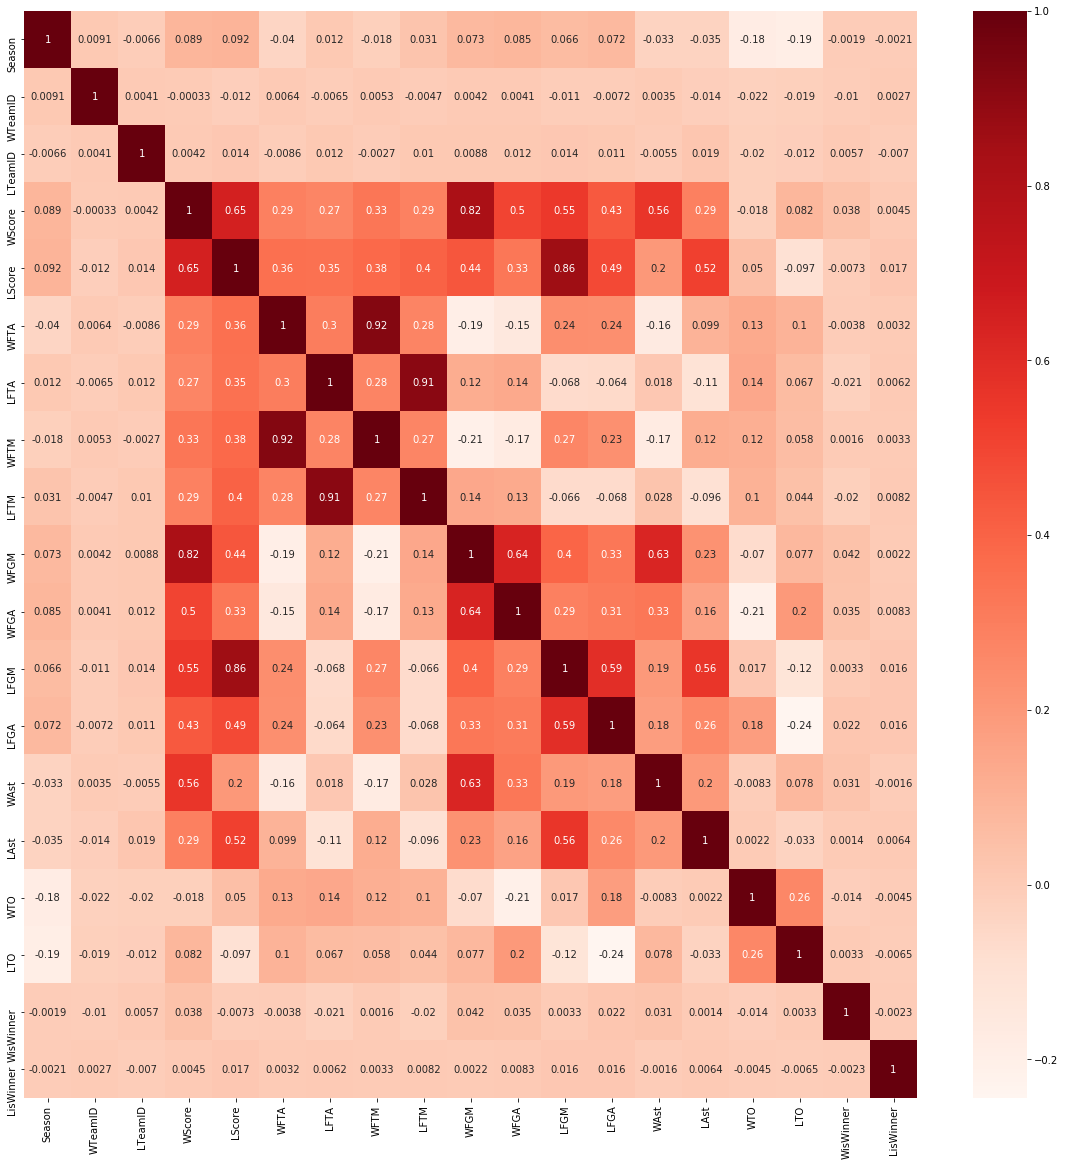

In [5]:
plt.figure(figsize=(20,20))
cor = new_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Transform Data

In [6]:
# getting seed to match their WTeamID or LTeamID
seed_df.head().transpose()
WSeeds = []
LSeeds = []

WAstTORatios = []
LAstTORatios = []

WFTRatios = []
LFTRatios = []

WFGRatios = []
LFGRatios = []

for index, row in new_df.iterrows():
    Wquery = "Season == {} and TeamID == {}".format(str(row['Season']),str(row["WTeamID"]))
    Lquery = "Season == {} and TeamID == {}".format(str(row['Season']),str(row["LTeamID"]))
    Wseed = seed_df.query(Wquery)["Seed"].values
    Lseed = seed_df.query(Lquery)["Seed"].values
    
    Wseed = Wseed[0] if len(Wseed) > 0 else 0
    Lseed = Lseed[0] if len(Lseed) > 0 else 0
    
    WSeeds.append(Wseed)
    LSeeds.append(Lseed)

    WAst = row["WAst"]
    LAst = row["LAst"]
    WTO = row["WTO"]
    LTO = row["LTO"]
    WTO += 0.1
    LTO += 0.1
    WAstTORatio = WAst/WTO 
    LAstTORatio = LAst/LTO 

    WAstTORatios.append(WAstTORatio)
    LAstTORatios.append(LAstTORatio)
        
    WFGA = row["WFGA"]
    WFGM = row["WFGM"]
    LFGA = row["LFGA"]
    LFGM = row["LFGM"]
    if WFGA == 0:
        WFGRatios.append(0)
    else:
        WFGRatios.append(WFGM/WFGA)

    if LFGA == 0:
        LFGRatios.append(0)
    else:
        LFGRatios.append(LFGM/LFGA)
    
    WFTA = row["WFTA"]
    WFTM = row["WFTM"]
    LFTA = row["LFTA"]
    LFTM= row["LFTM"]
    if WFTA == 0:
        WFTRatios.append(0)
    else:
        WFTRatios.append(WFTM/WFTA)

    if LFTA == 0:
        LFTRatios.append(0)
    else:
        LFTRatios.append(LFTM/LFTA)
new_df.shape

(87504, 20)

In [7]:
# new_df = new_df.assign(WSeed = WSeeds)
# new_df = new_df.assign(LSeed = LSeeds)
temp_df = pd.DataFrame({
"WSeeds" : WSeeds,
"LSeeds" : LSeeds,
"WAstTORatios" : WAstTORatios,
"LAstTORatios" : LAstTORatios,
"WFTRatios" : WFTRatios,
"LFTRatios" : LFTRatios,
"WFGRatios" : WFGRatios,
"LFGRatios" : LFGRatios
})
new_df = pd.concat([new_df,temp_df],axis = 1)
new_df.head().transpose()

,0,1,2,3,4
Season,2003,2003,2003,2003,2003
WTeamID,1104,1272,1266,1296,1400
LTeamID,1328,1393,1437,1457,1208
WScore,68,70,73,56,77
LScore,62,63,61,50,71
WLoc,N,N,N,N,N
WFTA,18,19,29,31,13
LFTA,22,20,23,15,27
WFTM,11,10,17,17,11
LFTM,16,9,14,8,17


In [8]:
# dropping columns
new_df = new_df.drop(["WAst","LAst","WFTM","LFTM","WFTA","LFTA","WFGA","LFGA","WFGM","LFGM","WTO","LTO"], axis = 1)

In [9]:
new_df.tail().transpose()

,87499,87500,87501,87502,87503
Season,2019,2019,2019,2019,2019
WTeamID,1153,1209,1277,1387,1463
LTeamID,1222,1426,1276,1382,1217
WScore,69,73,65,55,97
LScore,57,64,60,53,85
WLoc,N,N,N,N,H
WisWinner,0,0,0,0,0
LisWinner,0,0,0,0,0
WSeeds,Z07,Y14,W02,W13,W14
LSeeds,Y03,0,X02,0,0


## Model definition

In [10]:
# merging all teams into one dataset
Merge_Season = []
Merge_TeamID = []
Merge_Score = []
Merge_Loc = []
Merge_isWinner = []
Merge_Seeds = []
Merge_AstTORatios = []
Merge_FTRatios = []
Merge_FGRatios = []
i = 0;
while i < new_df['Season'].count():
    #add winning team stats
    Merge_Season.append(new_df.at[i,'Season'])
    Merge_TeamID.append(new_df.at[i,'WTeamID'])
    Merge_Score.append(new_df.at[i,'WScore'])
    Merge_Loc.append(new_df.at[i,'WLoc'])
    Merge_isWinner.append(1)
    Merge_Seeds.append(new_df.at[i,'WSeeds'])
    Merge_AstTORatios.append(new_df.at[i,'WAstTORatios'])
    Merge_FTRatios.append(new_df.at[i,'WFTRatios'])
    Merge_FGRatios.append(new_df.at[i,'WFGRatios'])
    
    #add losing team stats
    Merge_Season.append(new_df.at[i,'Season'])
    Merge_TeamID.append(new_df.at[i,'LTeamID'])
    Merge_Score.append(new_df.at[i,'LScore'])
    temp_loc = ''
    if new_df.at[i,'WLoc'] == 'H':
        temp_loc = 'A'
    if new_df.at[i,'WLoc'] == 'N':
        temp_loc = 'N'
    if new_df.at[i,'WLoc'] == 'A':
        temp_loc = 'H'
    Merge_Loc.append(temp_loc)
    Merge_isWinner.append(0)
    Merge_Seeds.append(new_df.at[i,'LSeeds'])
    Merge_AstTORatios.append(new_df.at[i,'LAstTORatios'])
    Merge_FTRatios.append(new_df.at[i,'LFTRatios'])
    Merge_FGRatios.append(new_df.at[i,'LFGRatios'])
    i = i + 1
merge_df = pd.DataFrame({"Season": Merge_Season,
                        "TeamID" : Merge_TeamID,
                        "Score" : Merge_Score,
                        "Loc" : Merge_Loc,
                        "IsWinner" : Merge_isWinner,
                        "Seeds" : Merge_Seeds,
                        "AstTORatios" : Merge_AstTORatios,
                        "FTRatios" : Merge_FTRatios,
                        "FGRatios" : Merge_FGRatios})
merge_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,174998,174999,175000,175001,175002,175003,175004,175005,175006,175007
Season,2003,2003,2003,2003,2003,2003,2003,2003,2003,2003,...,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019
TeamID,1104,1328,1272,1393,1266,1437,1296,1457,1400,1208,...,1153,1222,1209,1426,1277,1276,1387,1382,1463,1217
Score,68,62,70,63,73,61,56,50,77,71,...,69,57,73,64,65,60,55,53,97,85
Loc,N,N,N,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,H,A
IsWinner,1,0,1,0,1,0,1,0,1,0,...,1,0,1,0,1,0,1,0,1,0
Seeds,Y10,W01,Z07,W03,Y03,0,0,0,X01,0,...,Z07,Y03,Y14,0,W02,X02,W13,0,W14,0
AstTORatios,0.562771,0.441989,1.22137,0.578512,1.48515,0.743802,0.909091,0.471204,0.851064,1.18812,...,0.540541,1.12676,0.792079,0.851064,1.53846,2.78689,2.13115,0.810811,1.5493,0.769231
FTRatios,0.611111,0.727273,0.526316,0.45,0.586207,0.608696,0.548387,0.533333,0.846154,0.62963,...,0.76,0.611111,0.735294,0.647059,0.75,0.833333,0.466667,0.8,0.933333,0.791667
FGRatios,0.465517,0.415094,0.419355,0.358209,0.413793,0.30137,0.473684,0.367347,0.491803,0.387097,...,0.44,0.306452,0.4,0.359375,0.4,0.411765,0.372881,0.339286,0.603774,0.451613


In [12]:
raw_df = merge_df.copy()
raw_df = raw_df.drop(["Season","Loc","IsWinner","TeamID","Seeds"], axis = 1)
results_df = merge_df.copy()
results_df = results_df["IsWinner"]


df_array = []
df_array.append(raw_df[0:9232].copy())
df_array.append(raw_df[9233:18374].copy())
df_array.append(raw_df[18375:27724].copy())
df_array.append(raw_df[27725:37238].copy())
df_array.append(raw_df[37239:47324].copy())
df_array.append(raw_df[47325:57650].copy())
df_array.append(raw_df[57651:68148].copy())
df_array.append(raw_df[68149:78674].copy())
df_array.append(raw_df[78675:89166].copy())
df_array.append(raw_df[89167:99672].copy())
df_array.append(raw_df[99673:110312].copy())
df_array.append(raw_df[110313:121036].copy())
df_array.append(raw_df[121037:131744].copy())
df_array.append(raw_df[131745:142482].copy())
df_array.append(raw_df[142483:153272].copy())
df_array.append(raw_df[153273:164082].copy())


teams = []
average_Score = []
average_AstTORatios = []
average_FTRatios = []
average_FGRatios = []
counts = []
i = 0
for i in range(164083,175008):
    j = 0
    data_placed = False
    for j in range(0,len(teams)):
        if merge_df.at[i, 'TeamID'] == teams[j]:
            average_AstTORatios[j] = average_AstTORatios[j] + merge_df.at[i,'AstTORatios']
            average_FTRatios[j] = average_FTRatios[j] + merge_df.at[i,'FTRatios']
            average_FGRatios[j] = average_FGRatios[j] + merge_df.at[i,'FGRatios']
            average_Score[j] = average_Score[j] + merge_df.at[i,'Score']
            counts[j] = counts[j] + 1
            data_placed = True
    if data_placed == False:
        teams.append(merge_df.at[i,'TeamID'])
        average_AstTORatios.append(merge_df.at[i,'AstTORatios'])
        average_FTRatios.append(merge_df.at[i,'FTRatios'])
        average_FGRatios.append(merge_df.at[i,'FGRatios'])
        average_Score.append(merge_df.at[i,'Score'])
        counts.append(1)
        
wdf_array = []
wdf_array.append(results_df[0:9232].copy())
wdf_array.append(results_df[9233:18374].copy())
wdf_array.append(results_df[18375:27724].copy())
wdf_array.append(results_df[27725:37238].copy())
wdf_array.append(results_df[37239:47324].copy())
wdf_array.append(results_df[47325:57650].copy())
wdf_array.append(results_df[57651:68148].copy())
wdf_array.append(results_df[68149:78674].copy())
wdf_array.append(results_df[78675:89166].copy())
wdf_array.append(results_df[89167:99672].copy())
wdf_array.append(results_df[99673:110312].copy())
wdf_array.append(results_df[110313:121036].copy())
wdf_array.append(results_df[121037:131744].copy())
wdf_array.append(results_df[131745:142482].copy())
wdf_array.append(results_df[142483:153272].copy())
wdf_array.append(results_df[153273:164082].copy())


In [13]:
j = 0
for j in range(len(teams)):
    average_AstTORatios[j] = average_AstTORatios[j] / counts[j]
    average_FTRatios[j] = average_FTRatios[j] / counts[j]
    average_FGRatios[j] = average_FGRatios[j] / counts[j]
    average_Score[j] = average_Score[j] / counts[j]
    
team_df = pd.DataFrame({"Score" : average_Score,
                        "AstTORatios" : average_AstTORatios,
                        "FTRatios" : average_FTRatios,
                        "FGRatios" : average_FGRatios})

In [14]:
reg = []
for i in range(len(df_array)):
    reg.append(LogisticRegression(random_state=0).fit(df_array[i],wdf_array[i].transpose()))

## Trainning

In [15]:
errors = []
diff_array = []
# from 2003 to 2018
for year in range(0,16):
    this_year_diff = []
    this_year_error = []
    # find the differences between model output and label
    for i in range(0,16):
        if i != year:
            this_year_diff.append(reg[year].predict(df_array[i]) - wdf_array[i])
    this_year_diff_size = 0
    this_year_errors = 0
    for i in range(0,15):
        this_year_diff_size += this_year_diff[i].size
        this_year_errors += this_year_diff[i].abs().sum()
    errors.append(this_year_errors/this_year_diff_size)

In [16]:
minerror = min(errors)
minerror
modelindex = errors.index(minerror)
model = reg[modelindex]
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Result

In [17]:
prob = model.predict_proba(team_df)
trueprob = []
for i in range(len(team_df)):
    trueprob.append(prob[i][1])
maxprob = max(trueprob)
finalindex = trueprob.index(maxprob)
print("Team id:", teams[finalindex], "Probability of winning this year's tournament:", trueprob[finalindex])

Team id: 1211 Probability of winning this year's tournament: 0.9405142897823252
